# IMPORTACION DE LAS LIBRERIAS 

### LIBRERIAS PARA OBTENER LOS DATOS

In [47]:
import gzip
import os
import pandas as pd
import json
import ast

### LIBRERIAS PARA EL ANALISIS DE SENTIMIENTO


In [48]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import numpy as np


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ElRonconZzZ\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### LIBRERIA PARA TRANSFORMAR LAS FECHAS

In [49]:
from datetime import datetime

### LIBRERIAS PARA LA VISUALIZACION

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns


### LIBRERIAS PARA EL SISTEMA DE RECOMENDACION

In [51]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# TRANSFORMACION DE LOS ARCHIVOS EN DATAFRAMES 

Los datos estan almacenados en un archivo tipo JSON, por lo que utilizo las librerias (gzip, json y pandas) con el fin de crear un dataframe 

## steam_games

In [52]:
# Define la ruta al archivo (ajusta esta ruta según tu sistema)
ruta_archivo = 'C:/Users/ElRonconZzZ/OneDrive/Documents/PORYECTO 1/Datasets/Datasets formato gzip/steam_games.json.gz'

# Almacena los diccionarios generados a partir de cada línea del archivo
data_list = []

with gzip.open(ruta_archivo, 'rt', encoding='utf-8') as archivo:
    for line in archivo:
        # Crea un objeto data con cada línea como un objeto JSON y lo agrega a la lista
        data = json.loads(line)
        data_list.append(data)

# Crea un DataFrame de pandas a partir de la lista de diccionarios
df_steam_games_original = pd.DataFrame(data_list)

# Imprimir las primeras filas del DataFrame para verificar
print(df_steam_games_original.tail())


              publisher                                 genres  \
120440  Ghost_RUS Games  [Casual, Indie, Simulation, Strategy]   
120441           Sacada              [Casual, Indie, Strategy]   
120442     Laush Studio            [Indie, Racing, Simulation]   
120443         SIXNAILS                        [Casual, Indie]   
120444              NaN                                    NaN   

                        app_name                     title  \
120440            Colony On Mars            Colony On Mars   
120441  LOGistICAL: South Africa  LOGistICAL: South Africa   
120442             Russian Roads             Russian Roads   
120443       EXIT 2 - Directions       EXIT 2 - Directions   
120444               Maze Run VR                       NaN   

                                                      url release_date  \
120440  http://store.steampowered.com/app/773640/Colon...   2018-01-04   
120441  http://store.steampowered.com/app/733530/LOGis...   2018-01-04   
120442  

## Australian_user_reviews

In [53]:
ruta_archivo = 'C:/Users/ElRonconZzZ/OneDrive/Documents/PORYECTO 1/Datasets/Datasets formato gzip/user_reviews.json.gz'
data_list = []

with gzip.open(ruta_archivo, 'rt', encoding='utf-8') as archivo:
    for line in archivo.readlines():
        try:
            data_list.append(ast.literal_eval(line))
        except json.JSONDecodeError as e:
            print(f"Error al decodificar JSON: {e}")

df_user_reviews_original = pd.DataFrame(data_list)
print(df_user_reviews_original.tail())

                 user_id                                           user_url  \
25794  76561198306599751  http://steamcommunity.com/profiles/76561198306...   
25795           Ghoustik              http://steamcommunity.com/id/Ghoustik   
25796  76561198310819422  http://steamcommunity.com/profiles/76561198310...   
25797  76561198312638244  http://steamcommunity.com/profiles/76561198312...   
25798        LydiaMorley           http://steamcommunity.com/id/LydiaMorley   

                                                 reviews  
25794  [{'funny': '', 'posted': 'Posted May 31.', 'la...  
25795  [{'funny': '', 'posted': 'Posted June 17.', 'l...  
25796  [{'funny': '1 person found this review funny',...  
25797  [{'funny': '', 'posted': 'Posted July 21.', 'l...  
25798  [{'funny': '1 person found this review funny',...  


# Australian user items

In [54]:
ruta_archivo = 'C:/Users/ElRonconZzZ/OneDrive/Documents/PORYECTO 1/Datasets/Datasets formato gzip/users_items.json.gz'
data_list = []

with gzip.open(ruta_archivo, 'rt', encoding='utf-8') as archivo:
    for line in archivo.readlines():
        try:
            data_list.append(ast.literal_eval(line))
        except json.JSONDecodeError as e:
            print(f"Error al decodificar JSON: {e}")

df_users_items_original = pd.DataFrame(data_list)
print(df_users_items_original.tail())

                       user_id  items_count           steam_id  \
88305        76561198323066619           22  76561198323066619   
88306        76561198326700687          177  76561198326700687   
88307  XxLaughingJackClown77xX            0  76561198328759259   
88308        76561198329548331            7  76561198329548331   
88309        edward_tremethick            0  76561198331598578   

                                                user_url  \
88305  http://steamcommunity.com/profiles/76561198323...   
88306  http://steamcommunity.com/profiles/76561198326...   
88307  http://steamcommunity.com/id/XxLaughingJackClo...   
88308  http://steamcommunity.com/profiles/76561198329...   
88309     http://steamcommunity.com/id/edward_tremethick   

                                                   items  
88305  [{'item_id': '413850', 'item_name': 'CS:GO Pla...  
88306  [{'item_id': '11020', 'item_name': 'TrackMania...  
88307                                                 []  
88308 

Se crean unas copias de los df para evitar tener que volver a cargarlos en caso de que se cometa un error posteriormente y se requieran de los df originales.

In [55]:

df_steam_games = df_steam_games_original.copy()
df_user_reviews = df_user_reviews_original.copy()
df_users_items = df_users_items_original.copy()




## ANALISIS DE SENTIMIENTO

##### Se expande la columna de REVIEWS para poder aplicarle un metodo de analisis de sentimiento

In [56]:
#Se expanden la columna de reseñas del dataframe
df_exploded = df_user_reviews.explode('reviews')

# Se expanden claves del JSON en nuevas columnas
df_expandido = pd.json_normalize(df_exploded['reviews'])

# Se concatenan las columnas utiles de los df
df_reviews = pd.concat([df_exploded.drop(columns=['reviews','user_url']).reset_index(drop=True), df_expandido], axis=1)

In [57]:

def analizar_sentimiento(texto): #Se define la funcion que toma un valor y lo clasifica como positivo o negativo
    sia = SentimentIntensityAnalyzer()
    polaridad = sia.polarity_scores(texto)['compound']
    if polaridad>0:
        return 2 #asociado a un sentimiento positivo
    elif polaridad == 0:
        return 1 #asociado a un sentimiento neutro
    else:
        return 0 #asociado a un sentimiento negativo

#Aplicamos la funcion a los elementos del df de reseñas
df_reviews['sentimiento'] = df_reviews['review'].apply(
    lambda x: analizar_sentimiento(x)
        if pd.notna(x)
        else 1) #Esto significa que si no se tiene una reseña, se lo clasifique como neutro

Cantidad de datos registrados por sentimiento

In [58]:
print(df_reviews['sentimiento'].value_counts())

sentimiento
2    37658
1    11843
0     9832
Name: count, dtype: int64


## PREPARANDO LOS DATASETS PARA LA API

### UserFortGenre

In [59]:
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


Eliminar los registros donde todos los valores sean nulos

In [60]:
df_steam_games.dropna(how = "all", inplace = True)
df_steam_games.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
88310,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro
88311,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL
88312,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com
88313,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域
88314,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN


Imputación de valores faltantes en la columna de género utilizando la información disponible en la columna "tags".

In [61]:
df_steam_games[["genres","tags"]].head(15)
#La columna "tags" contiene muchos elementos que podrían usarse como géneros, pero también incluye información adicional. Para llenar los valores nulos en la columna de género, esta lista podría ser útil, pero primero sería necesario eliminar los elementos irrelevantes o extra que no se corresponden con géneros.

,genres,tags
88310,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]"
88311,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game..."
88312,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind..."
88313,"[Action, Adventure, Casual]","[Action, Adventure, Casual]"
88314,NaN,"[Action, Indie, Casual, Sports]"
88315,"[Action, Adventure, Simulation]","[Action, Adventure, Simulation, FPS, Shooter, ..."
88316,"[Free to Play, Indie, Simulation, Sports]","[Free to Play, Indie, Simulation, Sports]"
88317,"[Free to Play, Indie, Simulation, Sports]","[Free to Play, Indie, Simulation, Sports]"
88318,"[Free to Play, Indie, Simulation, Sports]","[Free to Play, Indie, Simulation, Sports]"
88319,"[Casual, Indie, Racing, Simulation]","[Indie, Casual, Simulation, Racing]"



Obtener una lista de generos unicos

In [62]:
# Utilizar explode para convertir las listas en filas individuales donde cada fila presenta un unico genero
df_exploded = df_steam_games['genres'].explode()

# Obtener los generos unicos
genres = df_exploded.unique()

print(genres)

['Action' 'Casual' 'Indie' 'Simulation' 'Strategy' 'Free to Play' 'RPG'
 'Sports' 'Adventure' nan 'Racing' 'Early Access' 'Massively Multiplayer'
 'Animation &amp; Modeling' 'Video Production' 'Utilities'
 'Web Publishing' 'Education' 'Software Training'
 'Design &amp; Illustration' 'Audio Production' 'Photo Editing'
 'Accounting']


Se eliminan todos los elementos de la columna tags que no sean generos, esta columna unicamente se empleara para rellenar los valores nulos de la columna generos.


In [63]:
def filtrar_elementos(lista):
    if type(lista) == list:
        return [elemento for elemento in lista if elemento in genres and elemento not in ['Free to Play', 'Early Access']]

# Aplicar la función a la columna 'tags'
df_steam_games['tags2'] = df_steam_games['tags'].apply(filtrar_elementos)

In [64]:
#Se llena los nulos de la columna genre con los de la columna tags
df_steam_games['genres'] = np.where(df_steam_games['genres'].notna(),
                                    df_steam_games['tags2'], df_steam_games['genres'])

La informacion en la columna de app_name es mas precisa y esta mas completa, y no se puede extraer nada de la columna title, por lo que solo se utilizara la de app_name

In [65]:
df_steam_games[(df_steam_games.app_name != df_steam_games.title) & ((pd.notna(df_steam_games.title))) & (pd.isna(df_steam_games.app_name))]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer,tags2


## Primera seleccion de columnas

Se escogen las columnas que se van a usar para el sistema de recomendacion 

In [66]:
df_steam_games_ml = df_steam_games[['id','app_name','genres','specs','tags','price','release_date']]

 Modificacion de la columna release_date para que presente formato de fecha

In [67]:
# Se cambia el tipo de dato de la columna fecha_lanzamiento a datetime
df_steam_games_ml['fecha_lanzamiento'] = pd.to_datetime(df_steam_games_ml['release_date'], errors='coerce')

#Se analiza cuantos valores nulos resultan en la columna fecha_lanzamiento
print('Nulos en columna de fecha_lanzamiento:',df_steam_games_ml['fecha_lanzamiento'].isnull().sum())

#Como el numero de nulos en la fecha_lanzamiento es considerable, se analiza si se perdieron fechas o que valores se tenian en estos registros el la columna fecha_lanzamiento
print('Valores que se tomaron en fecha_lanzamiento como nulos:',df_steam_games_ml['release_date'][df_steam_games_ml['fecha_lanzamiento'].isnull()].unique())

#Como se observa los nulos en fecha_lanzamiento en general indican que el juego todavia no fue lanzado aun o que estan proximos a ser lanzados, ademas de valores que previamente eran nulos, se eliminan estos registros ya que no suman a nuestro analisis ya que nos interesan los juegos que ya fueron jugados
df_steam_games_ml = df_steam_games_ml.dropna(subset='fecha_lanzamiento')

#Se crea una columna con los años donde se lanzo el juego
df_steam_games_ml['year'] = [fecha.year for fecha in df_steam_games_ml['fecha_lanzamiento']]

#Se eliminan las demas columnas relacionadas a la fecha
df_steam_games_ml = df_steam_games_ml.drop(['fecha_lanzamiento','release_date'],axis=1)


Nulos en columna de fecha_lanzamiento: 2352
Valores que se tomaron en fecha_lanzamiento como nulos: [nan 'Soon..' '2017' 'Beta测试已开启' 'Jun 2009' 'Oct 2010' 'Feb 2011'
 'Aug 2014' 'Sep 2014' 'Apr 2015' 'Apr 2016' 'Jul 2016' 'June 2016'
 'Coming Soon' 'Q2 2017' 'TBA' "When it's done" 'coming soon' 'Q2 2018'
 '2018' 'Winter 2017' 'soon' 'Mar 2018' '14 July' 'Jul 2017' 'Summer 2017'
 'Spring 2018' 'Winter 2018' 'To be Announced' 'October 2017' 'TBD'
 'Fall 2017' 'Nov 2017' 'Q1 2018' 'Dec 2017' 'Январь 2018' 'Soon'
 'First quarter of 2018' 'H2 2018' '21 Jun, 2017' '2018年初頭発売予定'
 'Please wait warmly' 'early access' 'SOON' 'Feb 2018'
 'Coming Soon/Próximamente' 'August 2017' '2018 [Now get free Pre Alpha]'
 '1st Quarter 2018' 'Jan 2018' '预热群52756441' '2018年1月' 'Coming soon'
 'Fall 2018'
 '0̵1̴0̵0̶1̷0̶0̵0̴ ̴0̶0̶1̶1̶0̷0̶1̵1̴ ̸0̶0̶1̶1̵0̶1̷0̴0̵ ̴0̶1̷0̸1̵0̷0̴1̶0̴ ̴0̷0̴1̷1̶0̶1̵1̷1̵ ̵'
 '"""Soon"""' 'Spring 2017' 'Demo coming soon.' 'Coming 2017'
 'Not yet available' "C'est bientôt...                

C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\1694284921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steam_games_ml['fecha_lanzamiento'] = pd.to_datetime(df_steam_games_ml['release_date'], errors='coerce')


### Se expanden las columnas que tienen elementos como listas/diccionarios

In [68]:
# Se emplea explode para expandir las listas de generos en la columna genres
df_user_for_genre = df_steam_games_ml.explode('genres')

In [69]:
# Se expande la lista de JSONs que contienen informacion sobre items
df_exploded = df_users_items.explode('items')

# Se expanden las claves del JSON en nuevas columnas
df_expandido = pd.json_normalize(df_exploded['items'])

# Se unen los dataframes dejando unicamente las columnas que nos interesan
df_items = pd.concat([df_exploded.drop(columns=['items_count','steam_id','user_url','items']).reset_index(drop=True), df_expandido], axis=1)

### Generacion del dataset para las consultas 1 y 2

In [70]:
#Se seleccionan las columnas que nos sirven para esta consulta. Como son pocos los registos con ids nulos se eliminan.
df_user_for_genre = df_user_for_genre[['id','genres','year']].dropna(subset='id')

# Se combinan los DataFrames en función del id del item
df_user_for_genre = pd.merge(df_user_for_genre, df_items, left_on='id', right_on='item_id', how='inner')

#Se eliminan los valores donde playtime_forever es =0 y ademas, como se encuentra en minutos, se transforma a horas.
df_user_for_genre = df_user_for_genre[df_user_for_genre.playtime_forever != 0]
df_user_for_genre['playtime_forever'] = [round(playtime/60,1) for playtime in df_user_for_genre['playtime_forever'] ]

#Se seleccionan las filas que son utiles para la consulta
df_user_for_genre = df_user_for_genre[['user_id','genres','year','playtime_forever']]

In [71]:
#Se crea un dataframe que presente el tiempo jugado agrupando por user_id, genero y año,
df_user_for_genre = (df_user_for_genre.groupby(['user_id','genres','year']).sum()
                   .reset_index())

Para cada genero se crea una dataframe donde para cada año se informa la cantidad de horas jugadas por el usuario que acumula mas horas de juego.

In [72]:
genres = df_user_for_genre.genres.unique()

df_user_for_genre_API = pd.DataFrame()


for genre in genres:

    df_filtered_by_genre = df_user_for_genre[df_user_for_genre['genres'] == genre]

    # Se calculan las horas jugadas para cada usuario
    user_hours = df_filtered_by_genre.groupby('user_id')['playtime_forever'].sum()

    # Se determina el usuario con mas horas de juego para el genero en cuestion
    max_time_played_user = user_hours.idxmax()

    # Se filtra df_filtered_by_genre para ver los registros del jugador con mas horas de juego
    max_user_df = df_filtered_by_genre[df_filtered_by_genre['user_id'] == max_time_played_user]

    # Se calculan las horas jugadas por año para el usuario principal
    hours_by_year = max_user_df.groupby('year')['playtime_forever'].sum().reset_index()

    # Se agregan al dataframe el genero y el jugador con mayor tiempo de juego
    hours_by_year['genre'] = genre.lower()
    hours_by_year['top_user_id'] = max_time_played_user

    # Se adicionan los datos al dataframe df_user_for_genre_API que presentara los datos de todos los generos
    df_user_for_genre_API = pd.concat([df_user_for_genre_API, hours_by_year], ignore_index=True)

# Visualiza el DataFrame resultante
print(df_user_for_genre_API.head())

   year  playtime_forever   genre top_user_id
0  1995               3.6  action     Sp3ctre
1  1997               4.0  action     Sp3ctre
2  1999               0.7  action     Sp3ctre
3  2000            1177.4  action     Sp3ctre
4  2001               4.2  action     Sp3ctre


In [73]:
def save_data(nombre_archivo, df, index=False):
    ruta_destino = os.path.join('C:/Users/ElRonconZzZ/OneDrive/Documents/PORYECTO 1/Datasets/Datasets formato gzip/', nombre_archivo + '.csv.gz')

    # Guarda el DataFrame como un archivo CSV comprimido
    df.to_csv(ruta_destino, index=index, compression='gzip')

    print(f"Archivo guardado en {ruta_destino}")


In [74]:
save_data('UserForGenre', df_user_for_genre_API)

Archivo guardado en C:/Users/ElRonconZzZ/OneDrive/Documents/PORYECTO 1/Datasets/Datasets formato gzip/UserForGenre.csv.gz


# PLAYTIME GENRE

In [75]:
df_user_for_genre

,user_id,genres,year,playtime_forever
0,--000--,Action,2006,15.4
1,--000--,Action,2009,88.8
2,--000--,Action,2010,0.4
3,--000--,Action,2011,108.6
4,--000--,Action,2012,1822.6
...,...,...,...,...
3555784,zzzmidmiss,Strategy,2010,3.4
3555785,zzzmidmiss,Strategy,2011,1.1
3555786,zzzmidmiss,Strategy,2012,15.4
3555787,zzzmidmiss,Strategy,2013,1.5


In [76]:
# Crear un DataFrame vacío para almacenar los resultados
df_play_time_genre_API = pd.DataFrame(columns=['genre', 'top_year'])

# Iterar sobre los géneros
for genre in genres:
    # Filtrar los registros por género
    df_filtered_by_genre = df_user_for_genre[df_user_for_genre['genres'] == genre]

    # Calcular las horas jugadas para cada año
    year_hours = df_filtered_by_genre.groupby('year')['playtime_forever'].sum()

    # Determinar el año que más se jugó para dicho género
    max_time_played_year = year_hours.idxmax()

    # Agregar los datos al DataFrame
    df_play_time_genre_API = pd.concat([df_play_time_genre_API, pd.DataFrame({'genre': [genre.lower()], 'top_year': [max_time_played_year]})], ignore_index=True)

# Visualizar el DataFrame resultante
print(df_play_time_genre_API.head(10))

                   genre top_year
0                 action     2012
1              adventure     2006
2                 casual     2015
3                  indie     2006
4  massively multiplayer     2006
5                    rpg     2012
6                 racing     2015
7             simulation     2006
8                 sports     2015
9               strategy     2012


In [77]:
save_data('PlayTimeGenre', df_play_time_genre_API)

Archivo guardado en C:/Users/ElRonconZzZ/OneDrive/Documents/PORYECTO 1/Datasets/Datasets formato gzip/PlayTimeGenre.csv.gz


## UserRecommended

### Seleccion de columnas

In [78]:
df_user_recommend = df_reviews[['posted','last_edited','item_id','recommend','sentimiento']]

### Eliminar nulos

In [79]:
df_user_recommend[pd.isna(df_user_recommend['recommend'])]

,posted,last_edited,item_id,recommend,sentimiento
137,NaN,NaN,NaN,NaN,1
177,NaN,NaN,NaN,NaN,1
2559,NaN,NaN,NaN,NaN,1
10080,NaN,NaN,NaN,NaN,1
13767,NaN,NaN,NaN,NaN,1
15493,NaN,NaN,NaN,NaN,1
19184,NaN,NaN,NaN,NaN,1
20223,NaN,NaN,NaN,NaN,1
25056,NaN,NaN,NaN,NaN,1
26257,NaN,NaN,NaN,NaN,1


In [80]:
df_user_recommend.dropna(subset='recommend',inplace=True)

C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\528203958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend.dropna(subset='recommend',inplace=True)


### Transformacion de la columna posted y last_edited


Primero se ajustará el formato de las columnas posted y last edited para facilitar su manipulación. Posteriormente, se utilizará la información de ambas columnas para generar una nueva columna en formato datetime, priorizando los datos de last edited cuando se especifique el año. Esto permitirá obtener información más precisa. Finalmente, la distribución de los años presentes será usada para imputar aquellos que falten en los registros, garantizando una mayor coherencia temporal en los datos.

In [81]:
#Se eliminan las palabras posted y last edited de las fechas
df_user_recommend['posted'] = df_user_recommend['posted'].str.replace('Posted ', "")
df_user_recommend['last_edited'] = df_user_recommend['last_edited'].str.replace('Last edited ', "")

C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\3848854578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['posted'] = df_user_recommend['posted'].str.replace('Posted ', "")
C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\3848854578.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['last_edited'] = df_user_recommend['last_edited'].str.replace('Last edited ', "")


In [82]:
df_user_recommend[~df_user_recommend.posted.str.contains(',')] #Se filtran los registros y a aquellos que no tienen coma, que son los que debido al formato que presentan los datos, no van a informar el año de posteo.

,posted,last_edited,item_id,recommend,sentimiento
6,February 3.,,248820,True,2
27,May 20.,,730,True,1
28,July 24.,,730,True,2
31,June 16.,,252950,True,2
32,June 11.,,440,True,1
...,...,...,...,...,...
59328,July 10.,,70,True,2
59329,July 8.,,362890,True,2
59330,July 3.,,273110,True,2
59331,July 20.,,730,True,2



Existen numerosos registros sin el año de publicación, por lo que se está considerando utilizar la columna last_edited para extraer esa información faltante.

In [83]:
df_user_recommend[(df_user_recommend.last_edited != '')
                        & (~df_user_recommend.posted.str.contains(','))
                        & (df_user_recommend.last_edited.str.contains(','))].tail()
                        #Estas dos condiciones son para traer unicamente los registros que no informan el año en posted, pero que si contiene coma(por lo que podrian llegar a informar el año) en last_edited
                        #Se observa que no se tiene ningun registro, asi que no es posible obtener los datos del año de esta forma.

,posted,last_edited,item_id,recommend,sentimiento


In [84]:
df_user_recommend[(df_user_recommend.last_edited != '')
                        & (df_user_recommend.posted.str.contains(','))
                        & (~df_user_recommend.last_edited.str.contains(','))].head()
#Estas dos condiciones son para traer unicamente los registros que no informan el año en last_edited, pero que si contiene coma(por lo que podrian llegar a informar el año) en posted
#Si bien es mejor utilizar las fechas de last_edited cuando sea posible debido a que es la ulitma actualizacion, perderiamos informacion con respecto a los años si no hacemos un tratamiento previo.

,posted,last_edited,item_id,recommend,sentimiento
87,"June 23, 2015.",April 4.,730,True,0
88,"September 11, 2015.",June 23.,570,True,2
195,"June 29, 2014.",June 26.,253710,False,2
216,"July 6, 2015.",March 8.,218620,True,2
361,"August 2, 2014.",March 31.,570,True,2


In [85]:
from dateutil import parser

def str_a_date(fecha):
    if fecha == '':
        return None
    try:
        # Limpieza de la cadena
        fecha = fecha.strip().replace(',', '')
        # Conversión de la fecha
        return parser.parse(fecha).strftime('%Y-%m-%d')
    except ValueError as e:
        print(f"Error al convertir la fecha: '{fecha}' - {e}")

In [86]:


# Aplicar la función a las columnas
df_user_recommend['posted_date'] = df_user_recommend.posted.apply(lambda date: str_a_date(date))
df_user_recommend['last_edited_date'] = df_user_recommend.last_edited.apply(lambda date: str_a_date(date))




C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\343847982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['posted_date'] = df_user_recommend.posted.apply(lambda date: str_a_date(date))
C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\343847982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['last_edited_date'] = df_user_recommend.last_edited.apply(lambda date: str_a_date(date))


In [87]:
df_user_recommend.head()

,posted,last_edited,item_id,recommend,sentimiento,posted_date,last_edited_date
0,"November 5, 2011.",,1250,True,2,2011-11-05,None
1,"July 15, 2011.",,22200,True,2,2011-07-15,None
2,"April 21, 2011.",,43110,True,2,2011-04-21,None
3,"June 24, 2014.",,251610,True,2,2014-06-24,None
4,"September 8, 2013.",,227300,True,2,2013-09-08,None


In [89]:
def aplicar_modificacion(row):
    #Se crea una funcion para seleccionar las columnas last_edited_date o posted_date cuando sea conveniente, generando una nueva columna que presente la informacion mas adecuada para el analisis.
    if pd.notna(row['last_edited_date']):
      day_month_last_edited = row['last_edited_date'].strftime('%d-%m')
      # Se obtiene el año siguiente a posted_date
      year_next_posted = row['posted_date'].year

    if pd.isna(row['last_edited_date']) or (row['last_edited_date'].day==29 and row['last_edited_date'].month==2):
        return row['posted_date'] #Cuando no se tenga datos en last_edited, o el dato sea un 29 de febrero, se tomara como dato la fecha en post_date
    elif not row['last_edited_date'].year in [1900, 1904]:
        return row['last_edited_date'] #Cuando se haya informado el año en last_edited, se tomara esta fecha
    elif (row['last_edited_date'].month < row['posted_date'].month) and (not row['posted_date'].year in [1900, 1904]):
        return pd.to_datetime(day_month_last_edited + '-' + str(year_next_posted+1), format='%d-%m-%Y') # Cuando se informe el año en posted, y ademas el mes en posted sea posterior al mes en last_edited, se tomara el mes y dia de last_edited, pero el año siguiente de la fecha en la columna posted.
    else:
        return pd.to_datetime(day_month_last_edited + '-' + str(year_next_posted), format='%d-%m-%Y') # Cuando se informe el año en posted, y ademas el mes de la fecha el posted sea anterior al mes de la fecha en last_edited, se tomara el mes y dia de la fecha last_edited, pero el año de la fecha en la columna posted
#Tener en cuenta que lo ultimo es un criterio adoptado, ya que no necesariamente es algo que deberia cumplirse.

df_user_recommend['date'] = df_user_recommend.apply(aplicar_modificacion, axis=1)

C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\2592069637.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['date'] = df_user_recommend.apply(aplicar_modificacion, axis=1)


In [90]:
# Asegúrate de que las columnas son de tipo datetime
df_user_recommend['posted_date'] = pd.to_datetime(df_user_recommend['posted_date'], errors='coerce')
df_user_recommend['last_edited_date'] = pd.to_datetime(df_user_recommend['last_edited_date'], errors='coerce')

# Ahora aplica la función
df_user_recommend['date'] = df_user_recommend.apply(aplicar_modificacion, axis=1)


C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\1808218174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['posted_date'] = pd.to_datetime(df_user_recommend['posted_date'], errors='coerce')
C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\1808218174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['last_edited_date'] = pd.to_datetime(df_user_recommend['last_edited_date'], errors='coerce')
C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\180821817

In [91]:
# Se va a imputar los años faltantes teniendo en cuenta la distribución de los datos en donde el año se informa
x = df_user_recommend[~df_user_recommend['date'].dt.year.isin([1900,1904])].date.dt.year #Se obtienen los años que fueron informados

#Se crea una mascara para filtrar los registros donde no se informo el año en posted
mask = df_user_recommend.date.dt.year.isin([1900,1904])

year_mean = x.mean()
year_median = x.median()
year_std = x.std()

# Se seleccionan las filas donde no hay fecha informada
imputation_indices = df_user_recommend[mask].index

# En base a la distribucion de los datos conocidos, se generan los años con los que se va a imputar el df
imputed_values = np.random.randint(low=int(year_mean - 2*year_std), high=int(year_mean + 2*year_std), size=len(imputation_indices))

imputed_dates = pd.Series(imputed_values, index=imputation_indices)

imputed_dates = imputed_dates.reindex(df_user_recommend.index) #Esto se realiza para que df_user_recommend y imputed_dates presenten los mismos indices y se pueda agregar imputed dates a df_user_recommend como columna

df_user_recommend['imputed_year'] = imputed_dates.fillna(0).astype(int)

# Concatenar los valores imputados con los valores existentes en la columna 'date'
df_user_recommend['date'] = df_user_recommend.apply(lambda row: row['date'].replace(year=int(2012))
                                                                  if (row['date'].month == 2 and (row.date.day == 29)) #Se toma el año bisiesto que mas datos presenta en el dataset para imputar los datos del años con fecha de 29 de febrero
                                                                  else(row['date'].replace(year=row['imputed_year'])
                                                                  if row.date.year in(1900,1904)
                                                                  else row['date']), axis=1)

C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\3395093040.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['imputed_year'] = imputed_dates.fillna(0).astype(int)
C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\3395093040.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend['date'] = df_user_recommend.apply(lambda row: row['date'].replace(year=int(2012))


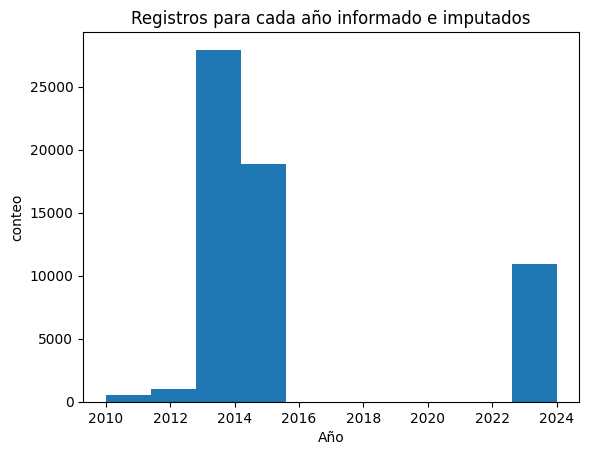

In [92]:
plt.hist(df_user_recommend.date.dt.year)
plt.title('Registros para cada año informado e imputados')
plt.xlabel('Año')
plt.ylabel('conteo')
plt.show()

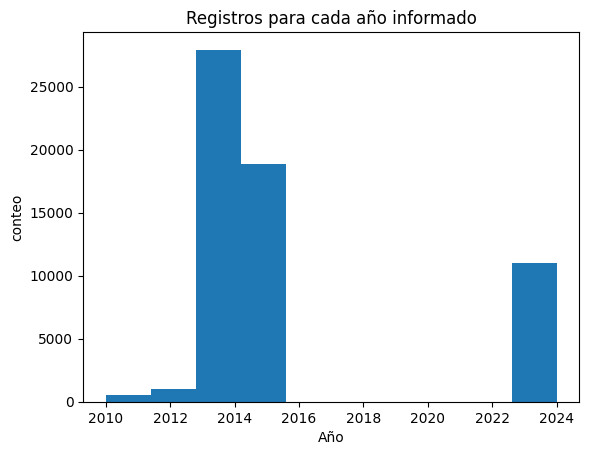

In [93]:
plt.hist(x)
plt.title('Registros para cada año informado')
plt.xlabel('Año')
plt.ylabel('conteo')
plt.show()

Se observa que la distribución original se ha modificado mínimamente, lo que sugiere que la estrategia adoptada para imputar los años faltantes es una aproximación adecuada. Esto indica que el método utilizado mantiene la coherencia con los datos existentes y es confiable para su uso en el análisis posterior.

### Seleccion de columnas para el analisis

In [94]:
df_user_recommend.drop(['posted','last_edited','posted_date','last_edited_date','imputed_year'],axis=1,inplace=True)
df_user_recommend.head()

C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\456698132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_recommend.drop(['posted','last_edited','posted_date','last_edited_date','imputed_year'],axis=1,inplace=True)


,item_id,recommend,sentimiento,date
0,1250,True,2,2011-11-05
1,22200,True,2,2011-07-15
2,43110,True,2,2011-04-21
3,251610,True,2,2014-06-24
4,227300,True,2,2013-09-08


In [95]:
# Se combinan los DataFrames en función del id del juego
df_user_recommend = pd.merge(df_steam_games, df_user_recommend, left_on='id', right_on='item_id', how='inner')

In [96]:
df_user_recommend = df_user_recommend[['date','app_name','recommend','sentimiento']]

In [97]:
df_user_recommend['year'] = df_user_recommend.date.dt.year
df_user_recommend

,date,app_name,recommend,sentimiento,year
0,2024-01-12,Carmageddon Max Pack,True,1,2024
1,2015-10-28,Half-Life,True,2,2015
2,2011-01-27,Half-Life,True,0,2011
3,2014-07-01,Half-Life,True,2,2014
4,2013-12-06,Half-Life,True,2,2013
...,...,...,...,...,...
53983,2014-10-26,Counter-Strike: Condition Zero,False,1,2014
53984,2013-12-08,Counter-Strike: Condition Zero,True,2,2013
53985,2015-01-05,Counter-Strike: Condition Zero,True,1,2015
53986,2014-10-31,Counter-Strike: Condition Zero,True,1,2014


### Modificacion del dataset para hacer la consulta 3 


Primero, se filtra el DataFrame para seleccionar únicamente los registros donde se ha recomendado el juego (recommend=True) y el sentimiento es positivo o neutro (valores 1 o 2). Luego, se aplica una función al conjunto de datos para obtener los tres juegos más recomendados por año.

In [98]:
df_user_recommend_API = df_user_recommend[(df_user_recommend.recommend) & (df_user_recommend.sentimiento.isin([1,2]))]  #Se filtran los registros que cumplen con la condicion para peretenecer al top 3 de juegos mas recomendados
df_user_recommend_API = df_user_recommend_API[['year','app_name','recommend']] #Se utiliza una unica columna entre recommend y sentimiento ya que se hara un conteo y no proporcionara data adicional mantener las 2

def top3(df_user_recommend_API):
  return (df_user_recommend_API.groupby(['year', 'app_name']).count() #cantidad de recomendaciones para cada juego en cada año
                            .groupby('year').apply(lambda x: x.nlargest(3, columns='recommend')) # tres juegos con el mayor número de recomendaciones para cada año
                            .reset_index(level=1, drop=True)
                            .drop('recommend',axis=1))

df_user_recommend_API = top3(df_user_recommend_API)
df_user_recommend_API

Empty DataFrame
Columns: []
Index: [(2010, Killing Floor), (2010, Team Fortress 2), (2010, Alien Swarm), (2011, Team Fortress 2), (2011, Portal 2), (2011, Garry's Mod), (2012, Team Fortress 2), (2012, Garry's Mod), (2012, Terraria), (2013, Team Fortress 2), (2013, Garry's Mod), (2013, Left 4 Dead 2), (2014, Team Fortress 2), (2014, Counter-Strike: Global Offensive), (2014, Garry's Mod), (2015, Counter-Strike: Global Offensive), (2015, Team Fortress 2), (2015, Garry's Mod), (2024, Counter-Strike: Global Offensive), (2024, Team Fortress 2), (2024, Garry's Mod)]

In [99]:
save_data('UserRecommend',df_user_recommend_API,True)

Archivo guardado en C:/Users/ElRonconZzZ/OneDrive/Documents/PORYECTO 1/Datasets/Datasets formato gzip/UserRecommend.csv.gz


## UserNotRecommend

In [100]:
#Se procede de manera similar que apra UsersRecommend
df_user_not_recommend_API = df_user_recommend[(~df_user_recommend.recommend) & (df_user_recommend.sentimiento == 0)]  #Se filtran los registros que cumplen con la condicion para peretenecer al top 3 de juegos mas recomendados
df_user_not_recommend_API = df_user_not_recommend_API[['year','app_name','recommend']] #Se utiliza una unica columna entre recommend y sentimiento ya que se hara un conteo y no proporcionara data adicional mantener las 2
df_user_not_recommend_API = top3(df_user_not_recommend_API)
df_user_not_recommend_API

Empty DataFrame
Columns: []
Index: [(2013, Call of Duty®: Ghosts), (2013, Half-Life: Before), (2013, Tactical Intervention), (2014, DayZ), (2014, Counter-Strike: Global Offensive), (2014, Loadout), (2015, PAYDAY 2), (2015, Counter-Strike: Global Offensive), (2015, DayZ), (2024, No Man's Sky), (2024, Counter-Strike: Global Offensive), (2024, Team Fortress 2)]

In [101]:
save_data('UserNotRecommend',df_user_not_recommend_API,True)

Archivo guardado en C:/Users/ElRonconZzZ/OneDrive/Documents/PORYECTO 1/Datasets/Datasets formato gzip/UserNotRecommend.csv.gz


### sentiment_analysis

Debemos obtener un dataset que según el año de lanzamiento, se devuelve una lista con la cantidad de reseñas positivas negativas o neutras.

### Seleccion de columnas

In [102]:
df_sentiment_analisis = df_user_recommend[['year','sentimiento']]

#### Conteo de reseñas positivas, negativas y neutras por año.

In [103]:
df_sentiment_analisis_API = pd.DataFrame(df_sentiment_analisis.groupby(['year','sentimiento']).size()).rename(columns={0:'conteo'}) # Con size se calcula el numero de filas en cada grupo (discriminado por año y sentimiento)
df_sentiment_analisis_API.head()

conteo
year sentimiento        
2010 0                 8
     1                 6
     2                36
2011 0                40
     1                60

In [104]:
save_data('sentiment_analysis',df_sentiment_analisis_API,True)

Archivo guardado en C:/Users/ElRonconZzZ/OneDrive/Documents/PORYECTO 1/Datasets/Datasets formato gzip/sentiment_analysis.csv.gz


# SISTEMA DE RECOMENDACION

Determinacion de variables importantes


Se utilizará una nube de palabras para identificar los temas más comentados por los jugadores sobre los juegos. Esto permitirá seleccionar adecuadamente las características que influirán en la recomendación de juegos.

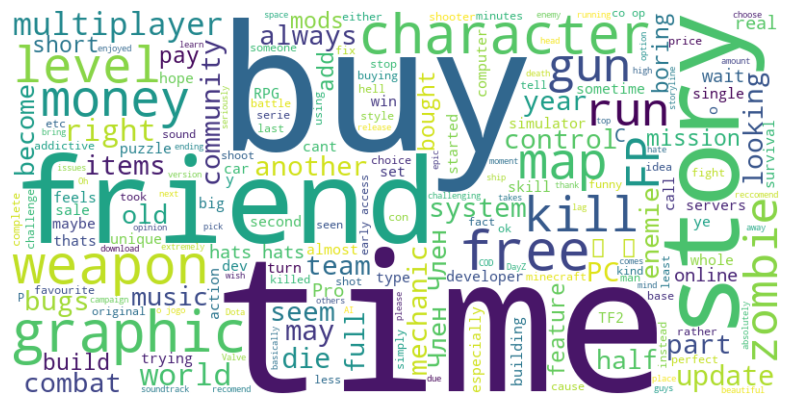

['time', 'buy', 'friend', 'story', 'graphic', 'character', 'free', 'weapon', 'money', 'map', 'level', 'kill', 'run', 'gun', 'zombie', 'FP', 'multiplayer', 'world', 'right', 'update', 'may', 'die', 'another', 'team', 'community', 'always', 'combat', 'looking', 'PC', 'year', 'bugs', 'control', 'seem', 'system', 'part', 'items', 'mechanic', 'full', 'music', 'enemie', 'Член Член', 'old', 'half', 'ㅤ ㅤ', 'become', 'mission', 'boring', 'short', 'pay', 'add']


In [105]:
from wordcloud import WordCloud, STOPWORDS

# Se utilizan las stopwords de la libreria wordcloud, y ademas se adicionan algunas palabras a la lista que son mas especificas para este dataset de juegos.
stopwords = set(STOPWORDS)

custom_stop_words = custom_stop_words = ['game', 'play', 'playing', 'steam', 'good', 'great',
    'fun', 'like', 'really', 'love', 'best',
    'awesome', 'amazing', 'recommend', 'enjoy', 'better',
    'worth', 'cool', 'fantastic', 'excellent', 'favorite',
    'nice', 'loved', 'interesting', 'highly', 'happy',
    'review', 'bad', 'reviewed',
    'experience', 'played', 'hour', 'hours',
    'worthwhile', 'problem', 'issue',
    'played', 'spent', 'waste',
    'one', 'make', 'games', 'will', 'much', 'still',
    'even', 'people', 'want', 'now', 'thing',
    'gameplay', 'lot', 'well', 'need', 'feel', 'player',
    'way', 'first', 'go', 'got', 'say',
    'think', 'give', 'made', 'HAT',
    'see', 'look', 'take', 'find', 'many',
    'know', 'start', 'use', 'pretty', 'NYAN',
    'work', 'u', 'new',
    'though', 'little', 'server', 'bit', 'mod',
    'hard', 'D', 'DLC', 'going', 'far',
    'everything', 'try', 'something',
    'back', 'come', 'life', 'Overall', 'must', 'quite',
    'never', 'e', 'around', 'day', 'long', 'every',
    'ing', 'bug', 'dont', 'end', 'keep', 'getting',
    'point', 'item', 'actually', 'anyone', 'different',
    'everyone', 'easy', 'put', 'stuff',
    'enough', 'times', 'found', 'mode',
    'alot', 'things', 'players', 'makes', 'right'
    'may', 'let', 'alway', 'probably', 'another'
    'looking', 'guy', 'without', 'yet', 'seem'
    'part', 'nothing', 'content', 'used',
    'sure', 'lots', 'making', 'simple', 'although',
    'change', 'de', 'definitely', 'help', 'fan',
    'anything', 'mean', 'thought', 'minute',
    'ㅤ ㅤ', 'im', 's', 'reason', 'two', 'needs',
    'able', 'might','looks', 'enjoyable',
    'already','done', 'gets', 'said', 'C'
    'ye']

stopwords.update(custom_stop_words)

# Se concatenan las reseñas para aplicar al str resultante la nube de palabras
texto = ' '.join(df_reviews['review'].dropna())

# Se crea un objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(texto)

#Se grafica la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#Se emplea el objeto de WordCloud para determinar un listado de las palabras mas importantes
frequencies = wordcloud.words_
top_words = list(frequencies.keys())
top_frequencies = list(frequencies.values())
print(top_words[:50])

Se seleccionaron algunas palabras de las 50 mas importantes y se las categorizaron en diferentes grupos:

- Aspectos del juego: story, map, character, level, items, music, graphic, mission, real, short, FP (posiblemente "First Person")..

- Caracteristicas del genero: weapon, kill, run, gun, zombie, combat, enemies, die.

- Multijugador y comunidad: multiplayer, team, community, friend.

- Sistema y actualizaciones: system, control, bugs, time, update, PC.

- Antiguedad: old, year.

- Aspectos economicos: free, pay, half, full, buy, money.

Los aspectos economicos por ejemplo, pueden deducirse de la columna price, ya que en la misma se indica el precio o si el juego es gratuito.


##### Generos mas importantes

In [106]:
important_genres = df_steam_games_ml.genres.explode().value_counts()
important_genres[important_genres>5000].sum()/important_genres.sum()

np.float64(0.9271991197878463)

Para simplificar el conjunto de datos y facilitar la aplicación de técnicas como OneHotEncoding, seleccionamos solo los géneros más relevantes, abarcando cerca del 91% de la información relacionada con géneros. Esta reducción en la cantidad de filas permite mantener la mayoría de los datos importantes mientras se disminuye la complejidad computacional del análisis.

Esto asegura que se capturen los principales géneros de interés sin sacrificar demasiada información y, al mismo tiempo, se mejora el rendimiento del modelo en términos de procesamiento y clasificación de los juegos.

In [107]:
important_genres=list(important_genres[important_genres >5000].index)
important_genres

['Indie', 'Action', 'Adventure', 'Casual', 'Strategy', 'Simulation', 'RPG']

##### Especificaciones mas importantes

A partir de los resultados obtenidos en la nube de palabras, se puede deducir que uno de los factores clave que influye en las recomendaciones de juegos es si estos son multijugador o para un solo jugador. Para obtener esta información, se analizará la columna "specs", que contiene detalles sobre las características técnicas de los juegos. Se buscarán palabras clave como "multiplayer", "single player" o similares, lo que permitirá clasificar los juegos según su modalidad de juego, añadiendo valor al sistema de recomendación.

In [108]:
important_specs = ['Single-player','Multi-player' ]
df_steam_games_ml.specs.explode().value_counts('specs')

specs
Single-player                 0.199710
Steam Achievements            0.122859
Downloadable Content          0.098911
Steam Trading Cards           0.093255
Steam Cloud                   0.075879
Multi-player                  0.062186
Full controller support       0.054892
Partial Controller Support    0.049550
Steam Leaderboards            0.044873
Co-op                         0.032746
Shared/Split Screen           0.030349
Cross-Platform Multiplayer    0.019193
Stats                         0.017000
Online Multi-Player           0.016655
Steam Workshop                0.014211
Captions available            0.012542
Includes level editor         0.010380
Local Multi-Player            0.008805
MMO                           0.007199
In-App Purchases              0.007113
Online Co-op                  0.007074
Local Co-op                   0.005437
Valve Anti-Cheat enabled      0.003596
Game demo                     0.002789
Commentary available          0.001465
Steam Turn Notifica

### Tags mas importantes

Para obtener mas informacion relacionada a las palabras de la nube, se empleara la columna tags:

- Music: Great Soundtrack
- Map: Open World
- FP: First-Person, FPS
- Zombies: Zombies
- story: Story rich
- weapon, kill, gun: Shooter

In [109]:
df_steam_games_ml.tags.explode().value_counts().head(60)

tags
Indie                    16162
Action                   11901
Adventure                 9108
Casual                    8797
Strategy                  7295
Simulation                6997
RPG                       5729
Singleplayer              4174
Multiplayer               2251
Free to Play              2213
Great Soundtrack          2161
Puzzle                    2001
2D                        1935
Atmospheric               1830
Platformer                1425
Early Access              1419
Story Rich                1400
Fantasy                   1322
Sports                    1308
Sci-fi                    1288
Anime                     1264
Open World                1263
Difficult                 1261
Horror                    1233
Massively Multiplayer     1232
Pixel Graphics            1228
Co-op                     1182
Female Protagonist        1152
Shooter                   1136
Racing                    1120
Funny                     1065
First-Person               963
Ret

In [110]:
important_tags = ['Great Soundtrack', 'Open World', 'First-Person', 'FPS', 'Zombies', 'Story Rich', 'Shooter']

In [111]:
df_ml = df_steam_games_ml.copy()

def filtrar_elementos2(lista_elementos, lista_elementos_interes):
    if type(lista_elementos) == list:
        return [elemento for elemento in lista_elementos if elemento in lista_elementos_interes]

df_ml['specs'] = df_steam_games['specs'].apply(lambda spec: filtrar_elementos2(spec, important_specs))
df_ml['genres'] = df_steam_games['genres'].apply(lambda spec: filtrar_elementos2(spec, important_genres))
df_ml['tags'] = df_steam_games['tags'].apply(lambda spec: filtrar_elementos2(spec, important_tags))

In [112]:
df_ml.specs.value_counts()

specs
[Single-player]                  19483
[Single-player, Multi-player]     6010
[Multi-player]                    1928
[]                                1693
Name: count, dtype: int64

In [113]:
df_ml.genres.value_counts()

genres
[Action]                                                    1796
[Simulation]                                                1716
[Action, Indie]                                             1450
[Casual, Simulation]                                        1370
[]                                                           988
                                                            ... 
[Simulation, Adventure, Indie, Casual, RPG, Strategy]          1
[Strategy, Action, Casual, Simulation, Indie]                  1
[Action, Adventure, RPG, Casual, Indie]                        1
[Action, Strategy, Indie, Casual, Simulation, Adventure]       1
[Casual, Simulation, RPG, Adventure]                           1
Name: count, Length: 1411, dtype: int64

In [114]:
df_ml.tags.value_counts()

tags
[]                                                                     24631
[Great Soundtrack]                                                      1047
[Open World]                                                             549
[Story Rich]                                                             521
[Shooter]                                                                312
                                                                       ...  
[Shooter, Open World, FPS, First-Person]                                   1
[Open World, Great Soundtrack, First-Person, FPS]                          1
[Shooter, FPS, Zombies]                                                    1
[First-Person, Zombies, Story Rich, FPS, Shooter]                          1
[FPS, First-Person, Story Rich, Shooter, Zombies, Great Soundtrack]        1
Name: count, Length: 360, dtype: int64

Se observa que la columna "tags", después de realizar el filtrado basado en los intereses de los usuarios, no proporciona información significativa y, por lo tanto, no será utilizada en el sistema de recomendación. En cambio, con el filtrado aplicado en las columnas "specs" y "genres", gran parte de la información relevante se mantiene intacta, lo que las convierte en variables útiles para el análisis y la creación de recomendaciones personalizadas para los jugadores.

### Filtrado para obtener unicamente los juegos mas recomendados para el sistema de recomendacion

A continuación, para mejorar el filtrado de los datos, se seleccionarán únicamente los juegos que han sido recomendados por los usuarios. Esto ayudará a enfocar el sistema de recomendaciones en los títulos más relevantes y preferidos por la comunidad.

In [115]:
conteo_recomendados = df_user_recommend[(df_user_recommend.recommend) & (df_user_recommend.sentimiento.isin([2]))].groupby('app_name').count()
conteo_no_recomendados = df_user_recommend[(~df_user_recommend.recommend) & (df_user_recommend.sentimiento.isin([0]))].groupby('app_name').count()
conteo_recomendados = conteo_recomendados['recommend']
conteo_recomendados.name = 'conteo_recomendados'

conteo_no_recomendados = conteo_no_recomendados['recommend']
conteo_no_recomendados.name = 'conteo_no_recomendados'

df_recomendados_no_recomendados = pd.concat([conteo_recomendados, conteo_no_recomendados], axis=1, keys=['conteo_recomendados', 'conteo_no_recomendados'])
df_recomendados_no_recomendados.conteo_recomendados.fillna(0,inplace=True)
df_recomendados_no_recomendados.conteo_no_recomendados.fillna(0,inplace=True) #Se rellenan los nulos con 0 para poder comparar ambas columnas posteriormente
df_juegos_mas_importantes = df_recomendados_no_recomendados[df_recomendados_no_recomendados['conteo_recomendados'] > df_recomendados_no_recomendados['conteo_no_recomendados']]
juegos_mas_importantes = list(df_recomendados_no_recomendados.index)

C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\2253218067.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_recomendados_no_recomendados.conteo_recomendados.fillna(0,inplace=True)
C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\2253218067.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

Se filtra el dataset para que se obtengan los registros de los juegos recomendados

In [116]:
df_ml = df_ml[df_ml.app_name.isin(juegos_mas_importantes)].drop('tags',axis=1)

Se eliminan los registros donde el genero es nulo, ya que es una de las features mas importante para la recomendacion

In [117]:
df_ml.dropna(subset=['genres'],inplace=True)

#### Transformacion de la columna precios

Se analiza que valores que no son flotantes se tiene en la columna de precios

In [118]:
no_float = []

for x in df_ml.price:
  if type(x)!=float:
    if x not in no_float:
      no_float.append(x)
print(no_float)

['Free', 'Free to Play', 'Play for Free!', 'Free To Play', 'Install Now', 'Play WARMACHINE: Tactics Demo', 'Free Mod', 'Free HITMAN™ Holiday Pack', 'Play the Demo', 'Third-party']


Dado que se encuentran valores como "free", sería adecuado reemplazarlos con un precio de 0. Además, términos como "install now" o "install theme" parecen referirse también a juegos gratuitos, por lo que estos valores se tratarán como juegos sin costo. Esto garantizará que se categoricen correctamente en el análisis de precios.

In [119]:
# Se por 0 el resto de los valores que no son numericos
df_ml['price'] = df_ml['price'].apply(lambda x: 0.0 if type(x) == str else x)
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2611 entries, 88338 to 120427
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        2610 non-null   object 
 1   app_name  2611 non-null   object 
 2   genres    2611 non-null   object 
 3   specs     2601 non-null   object 
 4   price     2527 non-null   float64
 5   year      2611 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 142.8+ KB


### Imputacion de valores faltantes para la columna precio

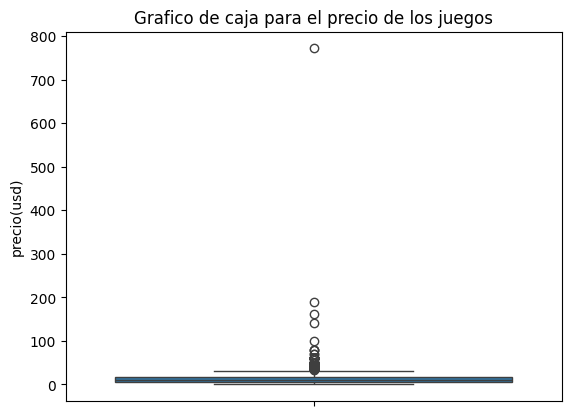

In [120]:
sns.boxplot(df_ml.price)
plt.title('Grafico de caja para el precio de los juegos')
plt.ylabel('precio(usd)')
plt.show()

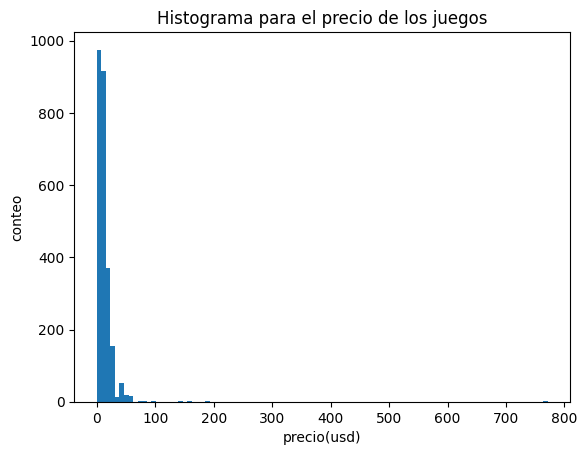

In [121]:
plt.hist(df_ml.price,bins=100)
plt.title('Histograma para el precio de los juegos')
plt.xlabel('precio(usd)')
plt.ylabel('conteo')
plt.show()

In [122]:
df_ml.price.quantile(0.95)

np.float64(29.99)

Los outliers dificultan la visualización clara del gráfico. Además, se observa que el 95% de los juegos tiene un precio inferior a 30 USD. Por ello, se filtrarán los registros para analizar gráficamente el comportamiento de los precios de estos juegos. Esto permitirá obtener una representación más precisa y comprensible de la distribución de precios en el dataset.

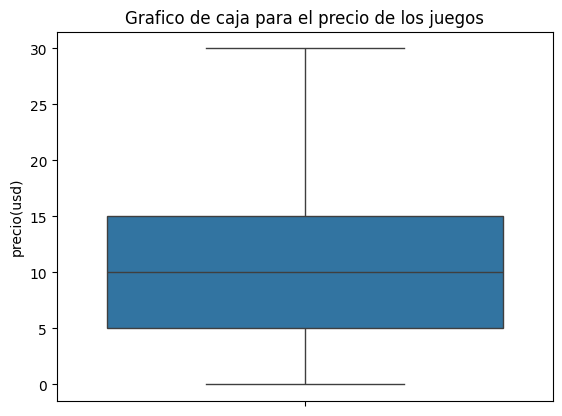

In [123]:
sns.boxplot(df_ml[df_ml.price<30].price)
plt.title('Grafico de caja para el precio de los juegos')
plt.ylabel('precio(usd)')
plt.show()

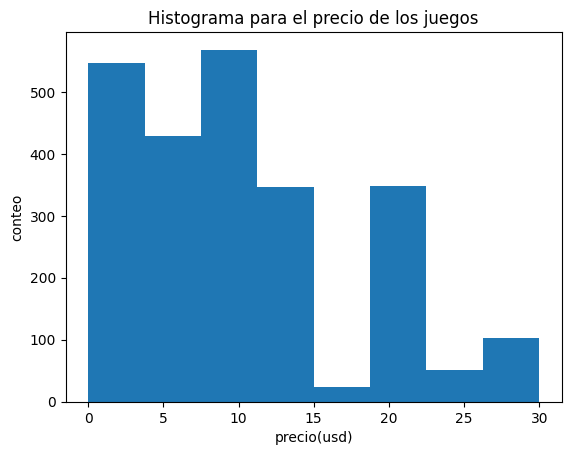

In [124]:
plt.hist(df_ml[df_ml.price<30].price,bins=8)
plt.title('Histograma para el precio de los juegos')
plt.ylabel('conteo')
plt.xlabel('precio(usd)')
plt.show()

In [125]:
df_ml.price.describe()

count    2527.000000
mean       12.406842
std        19.370052
min         0.000000
25%         4.990000
50%         9.990000
75%        15.990000
max       771.710000
Name: price, dtype: float64

Se filtrarán los registros para analizar específicamente los outliers, considerando un límite de 80 USD. Este monto se establece porque se conocen juegos que, al ser versiones completas o premium, pueden alcanzar este precio. Los valores por encima de 80 USD parecen excesivos y podrían ser errores, por lo que se estudiarán con mayor profundidad. Este enfoque permitirá identificar y comprender mejor las anomalías en la distribución de precios.

In [126]:
df_ml[df_ml.price>80]

,id,app_name,genres,specs,price,year
90111,248170,Clickteam Fusion 2.5,[],"[Single-player, Multi-player]",99.99,2013
90702,292180,X-Plane 10 Global - 64 Bit,"[Simulation, Adventure]","[Single-player, Multi-player]",771.71,2014
91569,342570,HIS (Heroes In the Sky),"[Action, Strategy, Casual, Simulation, RPG]","[Single-player, Multi-player]",139.92,2015
116808,285580,ACE - Arena: Cyber Evolution,"[Action, Indie, Strategy]","[Single-player, Multi-player]",189.96,2014
118663,211500,RaceRoom Racing Experience,"[Simulation, Action, Adventure, Casual]","[Single-player, Multi-player]",160.91,2013


Los precios registrados en la plataforma son correctos y no requieren corrección. Un juego que supera los 700 USD, por ejemplo, corresponde a simuladores de vuelo que implican procesos de creación costosos. 

Además, la distribución de precios está sesgada a la derecha, con una concentración en precios bajos y pocos valores altos. El precio promedio es mayor que la mediana debido a la influencia de los outliers. Por lo tanto, se utilizará la mediana para imputar los precios nulos.

In [127]:
median_price = df_ml.price.median()
median_price

np.float64(9.99)

In [128]:
df_ml['price'] = df_ml.price.apply(lambda x: x if pd.notna(x) else median_price)

#### Imputacion y eliminacion de nulos

In [129]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2611 entries, 88338 to 120427
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        2610 non-null   object 
 1   app_name  2611 non-null   object 
 2   genres    2611 non-null   object 
 3   specs     2601 non-null   object 
 4   price     2611 non-null   float64
 5   year      2611 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 142.8+ KB


In [130]:
df_ml[pd.isna(df_ml.id) | pd.isna(df_ml.app_name)]

,id,app_name,genres,specs,price,year
119271,NaN,Batman: Arkham City - Game of the Year Edition,"[Action, Adventure]",[Single-player],19.99,2012


Se tiene un unico registro con id nulo, por lo que se eliminara. Por otro lado, en la columna de specs se imputaran seleccionando "otro".

In [131]:
df_ml.dropna(subset='id',inplace=True)

In [132]:
df_ml['specs'].fillna('Otro', inplace=True)

C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\504555341.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ml['specs'].fillna('Otro', inplace=True)


In [133]:
df_ml

,id,app_name,genres,specs,price,year
88338,70,Half-Life,"[Action, Adventure]","[Single-player, Multi-player]",9.99,1998
88351,2400,The Ship: Murder Party,"[Indie, Action, RPG, Simulation, Strategy, Adv...","[Single-player, Multi-player]",9.99,2006
88365,3800,Advent Rising,[Action],[Single-player],9.99,2005
88366,1520,DEFCON,"[Strategy, Indie, Simulation]","[Single-player, Multi-player]",9.99,2006
88367,2420,The Ship: Single Player,"[Action, RPG, Indie]",[Single-player],9.99,2006
...,...,...,...,...,...,...
120418,40,Deathmatch Classic,[Action],[Multi-player],4.99,2001
120419,130,Half-Life: Blue Shift,"[Action, Adventure]",[Single-player],4.99,2001
120424,30,Day of Defeat,[Action],[Multi-player],4.99,2003
120426,13230,Unreal Tournament 2004: Editor's Choice Edition,"[Action, Adventure, RPG]","[Single-player, Multi-player]",14.99,2004


## Ids duplicados

Nos cercioramos de que no existan juegos duplicados en la data.

In [134]:
df_ml[df_ml.duplicated(subset='id')]

,id,app_name,genres,specs,price,year


#### Expansion de la columna genero y especificaciones

Por ultimo expandimos las filas de genre y specs para desplegar las listas correspondientes:

In [135]:
df_ml_exploded = df_ml.explode('genres').explode('specs')
df_ml_exploded.head()

,id,app_name,genres,specs,price,year
88338,70,Half-Life,Action,Single-player,9.99,1998
88338,70,Half-Life,Action,Multi-player,9.99,1998
88338,70,Half-Life,Adventure,Single-player,9.99,1998
88338,70,Half-Life,Adventure,Multi-player,9.99,1998
88351,2400,The Ship: Murder Party,Indie,Single-player,9.99,2006


#### Tratamiento de variables categoricas

A continuacion, empleando OneHotEncoder, se transformaran las variables categoricas para que puedan ser utilizadas en el modelo para el sistema de recomendacion.  

In [136]:
df_ml_exploded_dummie = pd.concat([df_ml_exploded,pd.get_dummies(df_ml_exploded, columns=['genres', 'specs']).drop(['year','price','id','app_name'],axis=1)],axis=1)
df_ml_exploded_dummie

,id,app_name,genres,specs,price,year,genres_Action,genres_Adventure,genres_Casual,genres_Indie,genres_RPG,genres_Simulation,genres_Strategy,specs_Multi-player,specs_Otro,specs_Single-player
88338,70,Half-Life,Action,Single-player,9.99,1998,True,False,False,False,False,False,False,False,False,True
88338,70,Half-Life,Action,Multi-player,9.99,1998,True,False,False,False,False,False,False,True,False,False
88338,70,Half-Life,Adventure,Single-player,9.99,1998,False,True,False,False,False,False,False,False,False,True
88338,70,Half-Life,Adventure,Multi-player,9.99,1998,False,True,False,False,False,False,False,True,False,False
88351,2400,The Ship: Murder Party,Indie,Single-player,9.99,2006,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120427,80,Counter-Strike: Condition Zero,Strategy,Multi-player,9.99,2004,False,False,False,False,False,False,True,True,False,False
120427,80,Counter-Strike: Condition Zero,Adventure,Single-player,9.99,2004,False,True,False,False,False,False,False,False,False,True
120427,80,Counter-Strike: Condition Zero,Adventure,Multi-player,9.99,2004,False,True,False,False,False,False,False,True,False,False
120427,80,Counter-Strike: Condition Zero,Simulation,Single-player,9.99,2004,False,False,False,False,False,True,False,False,False,True


In [137]:
df_ml_exploded_dummie = df_ml_exploded_dummie.drop(['genres','specs'],axis=1)


Se obtiene un listado de juego con todos los generos a los que pertenece

In [138]:
df_ml_final = df_ml_exploded_dummie.groupby(['id','app_name', 'price', 'year']).sum().reset_index()

#### Escalado de los datos

Se escalan los datos ya que se trabaja con el modelo de la similitud del coseno, que es un modelo basado en distancias.

In [139]:
columnas_consideradas = list(df_ml_final.columns)[2:] #Seleccionamos todas las columnas menos app_name y id
esc = StandardScaler()
data_esc = esc.fit_transform(df_ml_final[columnas_consideradas])

#### Obtencion de la matriz de utilidad aplicando la similitud del coseno

In [140]:
df_esc = pd.DataFrame(data_esc, columns = columnas_consideradas)
matriz = pd.DataFrame(cosine_similarity(df_esc, df_esc))
matriz2 = pd.concat([df_ml_final[['id','app_name']], matriz], axis=1)

### Ajustando el dataframe para que sea apto para la API

In [141]:
matriz2 = pd.concat([df_ml_final[['id','app_name']], matriz], axis=1)
matriz2.head()


,id,app_name,0,1,2,3,4,5,6,7,...,2600,2601,2602,2603,2604,2605,2606,2607,2608,2609
0,10,Counter-Strike,1.000000,0.344200,0.729763,0.217007,0.316610,-0.017843,-0.051001,-0.239808,...,-0.163381,0.560831,-0.324569,0.563749,0.213349,0.538699,0.342965,0.117804,-0.282481,0.067792
1,10090,Call of Duty: World at War,0.344200,1.000000,0.519907,0.469570,0.674514,0.402659,0.379592,-0.044679,...,-0.443785,0.499546,-0.281393,0.387943,0.175214,0.440629,-0.112394,-0.603133,0.147207,0.102956
2,10130,TimeShift™,0.729763,0.519907,1.000000,0.348952,0.185462,0.184343,0.203538,-0.341157,...,-0.246358,0.459617,-0.523828,0.298997,0.446216,0.939364,0.530273,-0.236862,-0.310993,-0.351953
3,10150,Prototype™,0.217007,0.469570,0.348952,1.000000,0.138708,0.313819,0.938824,0.403419,...,-0.320414,0.371633,0.272659,0.136378,0.548594,0.218422,-0.007141,-0.334391,-0.003138,-0.198896
4,10180,Call of Duty®: Modern Warfare® 2,0.316610,0.674514,0.185462,0.138708,1.000000,0.005504,0.064984,0.261443,...,-0.105392,0.211295,-0.378319,0.468730,0.023473,0.112517,-0.442184,-0.292142,0.163918,0.461519


In [142]:
matriz2['id'] = matriz2.id.astype(int)

In [143]:
#Se crea un listado compuesto por 'id', 'app_name' y los ids de los juegos para generar los nombres para las columnas del df
nombre_columnas = [str(x) for x in list(matriz2.id)]
nombre_columnas.insert(0,'id')
nombre_columnas.insert(1,'app_name')
matriz2.columns = nombre_columnas

In [144]:
# Asegúrate de que 'matriz2' sea tu DataFrame
ruta_destino = 'C:/Users/ElRonconZzZ/OneDrive/Documents/PORYECTO 1/matriz_parquet.parquet'

# Guarda el DataFrame como archivo Parquet
matriz2.to_parquet(ruta_destino, index=True)

# No necesitas ningún código adicional para descargar en entornos locales; el archivo estará en la ruta especificada
print(f"Archivo guardado en: {ruta_destino}")

Archivo guardado en: C:/Users/ElRonconZzZ/OneDrive/Documents/PORYECTO 1/matriz_parquet.parquet


# EDA

Se va a analizar la relación entre diversas variables para identificar características clave del conjunto de datos. En primer lugar, se examinará cómo los usuarios han interactuado en términos de tiempo de juego a lo largo del tiempo y en función de diferentes géneros.

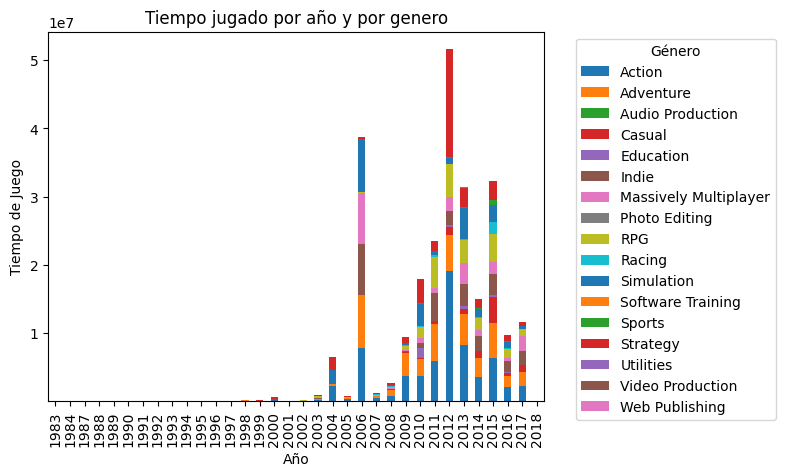

In [145]:
#se crea un pivot table para poder generar un grafico de columnas apiladas
pivot_table = df_user_for_genre.pivot_table(index='year', columns='genres', values='playtime_forever', aggfunc='sum')

pivot_table.plot(kind='bar', stacked=True)
plt.xlabel('Año')
plt.ylabel('Tiempo de Juego')
plt.title('Tiempo jugado por año y por genero')
plt.xticks(rotation=90)  #Para mayor legibilidad
plt.legend(title='Género', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Se observa que los tiempos de juego antes de 2003 eran significativamente bajos en comparación con los años posteriores. A partir de ese año, se experimenta un crecimiento notable en el consumo de videojuegos. Por lo tanto, nos enfocaremos en analizar el comportamiento de los jugadores en estos años para obtener conclusiones más relevantes.

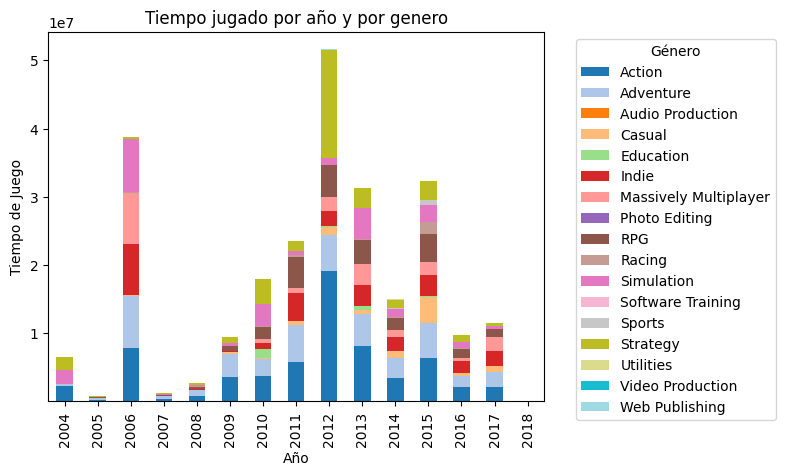

In [146]:
pivot_table = df_user_for_genre[df_user_for_genre.year>2003].pivot_table(index='year', columns='genres', values='playtime_forever', aggfunc='sum')

# Crear el gráfico de barras apiladas con Seaborn
pivot_table.plot(kind='bar', stacked=True,cmap='tab20')
plt.xlabel('Año')
plt.ylabel('Tiempo de Juego')
plt.title('Tiempo jugado por año y por genero')
plt.xticks(rotation=90) #Para mayor legibilidad
plt.legend(title='Género', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Se puede evidenciar que a lo largo de los años los generos mas importante han sido:
- Accion
- Aventura
- RPG
- Indie
- Strategy
- Simulation
Se ha establecido que el año 2012 marca un pico en las horas máximas de juego, tras el cual se observa una disminución general en el tiempo de juego. Sin embargo, esta tendencia no se aplica a todos los géneros; por ejemplo, en el género de acción se confirma esta disminución, mientras que en géneros como estrategia y simulación, las horas jugadas disminuyeron significativamente en 2012. Por lo tanto, no se trata de una tendencia uniforme para todos los géneros.

A continuacion se van a analizar las recomendaciones por año

In [147]:
df_user_recommend2 = df_user_recommend[(df_user_recommend.recommend) & (df_user_recommend.sentimiento.isin([1,2]))]  #Se filtran los registros que cumplen con la condicion para peretenecer al top 3 de juegos mas recomendados
df_user_recommend2 = df_user_recommend2[['year','app_name','recommend']]
df_user_not_recommend2 = df_user_recommend[(~df_user_recommend.recommend) & (df_user_recommend.sentimiento == 0)]  #Se filtran los registros que cumplen con la condicion para peretenecer al top 3 de juegos mas recomendados
df_user_not_recommend2 = df_user_not_recommend2[['year','app_name','recommend']]
df_rec = pd.concat([df_user_recommend2,df_user_not_recommend2])
df_rec[['year','recommend']].groupby('year').count

<bound method GroupBy.count of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x0000017B88937770>>

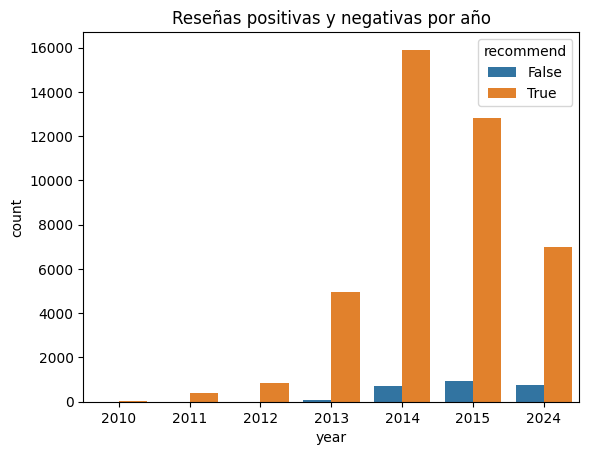

In [148]:
sns.countplot(data=df_rec,x='year',hue='recommend')
plt.title('Reseñas positivas y negativas por año')
plt.show()

Se observa que la mayoría de las reseñas son positivas, con una tendencia creciente hasta 2014 en la cantidad de comentarios sobre los juegos. Sin embargo, en 2015, esta tendencia parece haber disminuido, y las reseñas de 2016 son escasas, lo que podría deberse a problemas en la carga de datos. Además, la imputación de datos faltantes, especialmente en relación con las fechas de publicación y edición, puede haber influido en la cantidad de reseñas reportadas.




In [149]:
df_user_recommend.date.max()

Timestamp('2024-09-18 00:00:00')

A continuacion vamos a determinar si existe una relacion entre el tiempo de juego y su precio

In [150]:
df_steam_games_ml2 = df_steam_games_ml[['id','price','year']]
# Se toma por 0 los valores que no son numericos en la columna precio
df_steam_games_ml2['price'] = df_steam_games_ml2['price'].apply(lambda x: 0.0 if type(x) == str else x)
df_merge_price_time = pd.merge(df_steam_games_ml2, df_items[['item_id','playtime_forever']], left_on='id', right_on='item_id', how='inner')

C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\2303824681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steam_games_ml2['price'] = df_steam_games_ml2['price'].apply(lambda x: 0.0 if type(x) == str else x)


In [151]:
df_merge_price_time.drop('item_id',axis=1,inplace=True)

In [152]:
df_merge_price_time[df_merge_price_time.playtime_forever !=0]

,id,price,year,playtime_forever
0,282010,9.99,1997,5.0
4,282010,9.99,1997,13.0
5,282010,9.99,1997,110.0
6,282010,9.99,1997,13.0
7,282010,9.99,1997,8.0
...,...,...,...,...
4208381,80,9.99,2004,203.0
4208383,80,9.99,2004,244.0
4208384,80,9.99,2004,7.0
4208390,80,9.99,2004,9.0


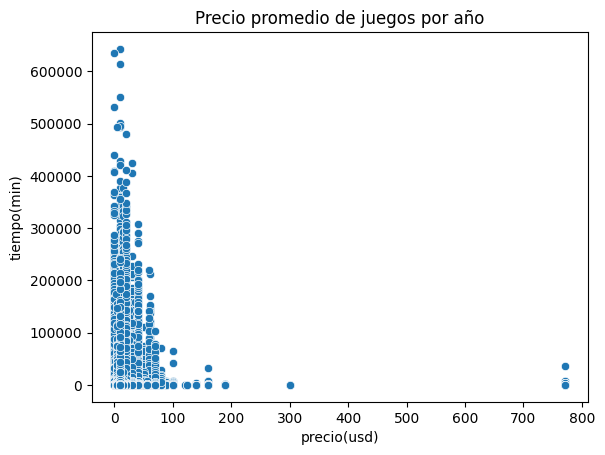

In [153]:
sns.scatterplot(data=df_merge_price_time,x='price',y='playtime_forever')
plt.title('Relacion entre tiempo juego y precio')
plt.xlabel('precio(usd)')
plt.ylabel('tiempo(min)')
plt.title('Precio promedio de juegos por año')
plt.show()

Eliminaremos los outliers

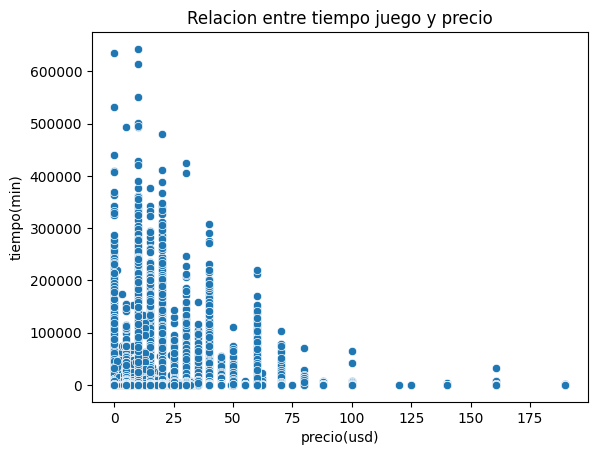

In [154]:
sns.scatterplot(data=df_merge_price_time[df_merge_price_time.price<200],x='price',y='playtime_forever')
plt.title('Relacion entre tiempo juego y precio')
plt.xlabel('precio(usd)')
plt.ylabel('tiempo(min)')
plt.show()

De esta manera se observa una clara tendencia en la que los juegos mas jugados son los mas economicos.

A continuacion se va a analizar como fueron variando a lo largo del tiempo el precio de los juegos:

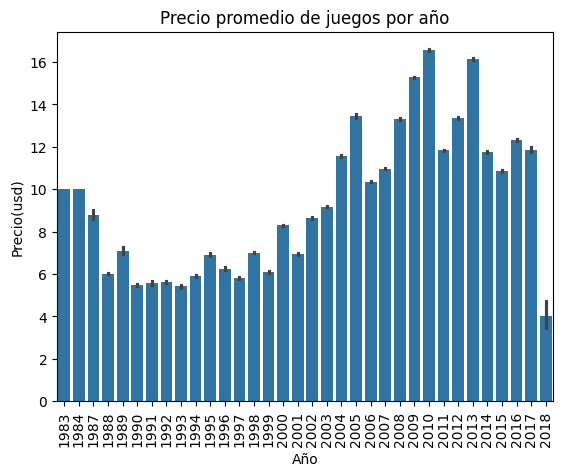

In [155]:
sns.barplot(data=df_merge_price_time,x='year',y='price')
plt.xlabel('Año')
plt.ylabel('Precio(usd)')
plt.title('Precio promedio de juegos por año')
plt.xticks(rotation=90) #Para mayor legibilidad
plt.show()

Inicialmente, los precios de los juegos eran relativamente altos, pero en 1987 disminuyeron significativamente y se mantuvieron estables hasta 1999. A partir de ese año, los precios experimentaron un fuerte aumento, llegando a más del doble en 2010 (de aproximadamente 6 a 16 USD). Posteriormente, comenzó una tendencia decreciente en el precio de los juegos.


Por ultimo se estudiara en que meses se tiene una mayor afluencia de usuarios.



In [156]:
df_time_month = df_steam_games[['id','release_date']]

In [157]:
# Se cambia el tipo de dato de la columna fecha_lanzamiento a datetime
df_time_month['fecha_lanzamiento'] = pd.to_datetime(df_time_month['release_date'], errors='coerce')

#Se analiza cuantos valores nulos resultan en la columna fecha_lanzamiento
print('Nulos en columna de fecha_lanzamiento:',df_time_month['fecha_lanzamiento'].isnull().sum())

#Como el numero de nulos en la fecha_lanzamiento es considerable, se analiza si se perdieron fechas o que valores se tenian en estos registros el la columna fecha_lanzamiento
print('Valores que se tomaron en fecha_lanzamiento como nulos:',df_time_month['release_date'][df_time_month['fecha_lanzamiento'].isnull()].unique())

#Como se observa los nulos en fecha_lanzamiento en general indican que el juego todavia no fue lanzado aun o que estan proximos a ser lanzados, ademas de valores que previamente eran nulos, se eliminan estos registros ya que no suman a nuestro analisis ya que nos interesan los juegos que ya fueron jugados
df_time_month = df_time_month.dropna(subset='fecha_lanzamiento')

#Se crea una columna con los años donde se lanzo el juego
df_time_month['month'] = [fecha.month for fecha in df_time_month['fecha_lanzamiento']]

#Se eliminan las demas columnas relacionadas a la fecha
df_time_month = df_time_month.drop(['fecha_lanzamiento','release_date'],axis=1)

Nulos en columna de fecha_lanzamiento: 2352
Valores que se tomaron en fecha_lanzamiento como nulos: [nan 'Soon..' '2017' 'Beta测试已开启' 'Jun 2009' 'Oct 2010' 'Feb 2011'
 'Aug 2014' 'Sep 2014' 'Apr 2015' 'Apr 2016' 'Jul 2016' 'June 2016'
 'Coming Soon' 'Q2 2017' 'TBA' "When it's done" 'coming soon' 'Q2 2018'
 '2018' 'Winter 2017' 'soon' 'Mar 2018' '14 July' 'Jul 2017' 'Summer 2017'
 'Spring 2018' 'Winter 2018' 'To be Announced' 'October 2017' 'TBD'
 'Fall 2017' 'Nov 2017' 'Q1 2018' 'Dec 2017' 'Январь 2018' 'Soon'
 'First quarter of 2018' 'H2 2018' '21 Jun, 2017' '2018年初頭発売予定'
 'Please wait warmly' 'early access' 'SOON' 'Feb 2018'
 'Coming Soon/Próximamente' 'August 2017' '2018 [Now get free Pre Alpha]'
 '1st Quarter 2018' 'Jan 2018' '预热群52756441' '2018年1月' 'Coming soon'
 'Fall 2018'
 '0̵1̴0̵0̶1̷0̶0̵0̴ ̴0̶0̶1̶1̶0̷0̶1̵1̴ ̸0̶0̶1̶1̵0̶1̷0̴0̵ ̴0̶1̷0̸1̵0̷0̴1̶0̴ ̴0̷0̴1̷1̶0̶1̵1̷1̵ ̵'
 '"""Soon"""' 'Spring 2017' 'Demo coming soon.' 'Coming 2017'
 'Not yet available' "C'est bientôt...                

C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\3395013621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_month['fecha_lanzamiento'] = pd.to_datetime(df_time_month['release_date'], errors='coerce')


C:\Users\ElRonconZzZ\AppData\Local\Temp\ipykernel_8768\2267539478.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(nombres_meses)


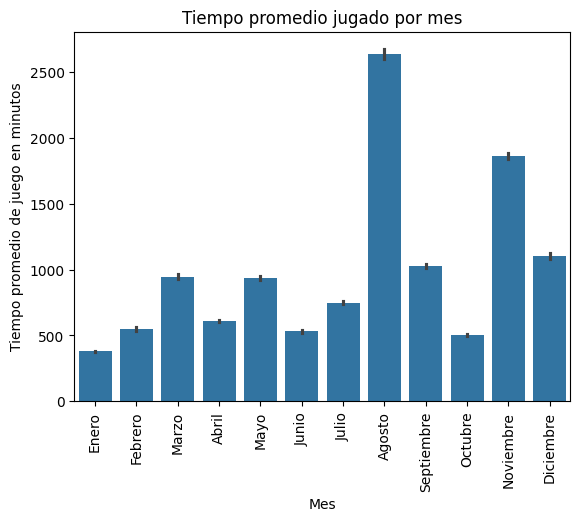

In [158]:
df_merge_time_month = pd.merge(df_time_month, df_items[['item_id','playtime_forever']], left_on='id', right_on='item_id', how='inner').drop('id',axis=1) #Se unen los df para relacionar la columna de mes con la de tiempo de juego
sns.barplot(df_merge_time_month,x='month',y='playtime_forever')
nombres_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
plt.xlabel('Mes')
plt.ylabel('Tiempo promedio de juego en minutos')
plt.title('Tiempo promedio jugado por mes')
plt.gca().set_xticklabels(nombres_meses)
plt.xticks(rotation=90)
plt.show()

Se observa que el mes mas jugado es agosto, seguido por noviembre. Luego tambien es interesante observar que en marzo, mayo septiembre y diciembre el tiempo promedio jugado es similar.